### Goal is compare size and accuracy of various models on finance sentiment and deciding final model for deployment

In [1]:
#basic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import datasets
import transformers
from tqdm import tqdm

In [2]:
#load dataset
#loading instances where 3/4 annotators agreed
from datasets import load_dataset
news_sent = load_dataset('takala/financial_phrasebank','sentences_75agree')

Generating train split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [3]:
news_sent = news_sent['train'].train_test_split(train_size=0.8)

In [4]:
news_sent

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2762
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 691
    })
})

### Exploring dataset

In [5]:
news_sent.set_format("pd")

In [6]:
df = news_sent['train'][:]

In [7]:
df.head()

,sentence,label
0,Philips was not available to comment on the re...,1
1,"A total of 38,244 new Citycon shares with a no...",1
2,Cablevision Systems Corp. CVC Their Madison Sq...,1
3,"`` Over the years , the color orange has becom...",1
4,The number of magazine and newspaper readers r...,1


### extract meaning of labels from dataset

In [8]:
def int2str_row(row):
    return news_sent['train'].features['label'].int2str(row)

In [9]:
df['sentiment'] = df['label'].apply(int2str_row)

In [10]:
df.head()

,sentence,label,sentiment
0,Philips was not available to comment on the re...,1,neutral
1,"A total of 38,244 new Citycon shares with a no...",1,neutral
2,Cablevision Systems Corp. CVC Their Madison Sq...,1,neutral
3,"`` Over the years , the color orange has becom...",1,neutral
4,The number of magazine and newspaper readers r...,1,neutral


In [11]:
df['sentiment'].value_counts()

sentiment
neutral     1705
positive     712
negative     345
Name: count, dtype: int64

### 1 -> neutral 2->positive 0->negative

In [12]:
df['wrd_len'] = df['sentence'].str.split().apply(len)

### words per sentence

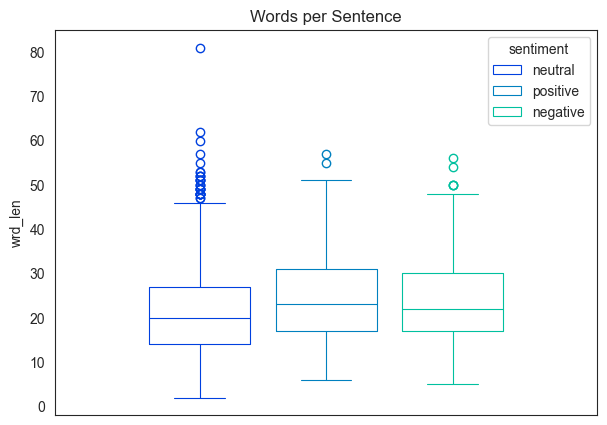

In [13]:
plt.figure(figsize=(7,5))
sns.set_style('white')
sns.boxplot(y='wrd_len',data=df,width=0.7,gap=0.2,fill=False,hue='sentiment',linewidth=0.8,palette='winter')
plt.title('Words per Sentence')
plt.show()
#every sentiment news has around 50 words which is a lot less than context length of 512

/var/folders/xw/knd54pd91c7cw57n21dntvx80000gn/T/ipykernel_59022/668373761.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment',data=df,width=0.5,gap=0.2,palette='winter')


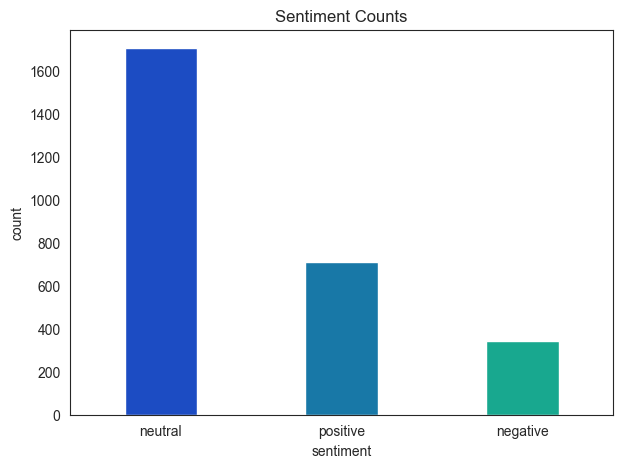

In [14]:
plt.figure(figsize=(7,5))
sns.set_style('white')
sns.countplot(x='sentiment',data=df,width=0.5,gap=0.2,palette='winter')
plt.title('Sentiment Counts')
plt.show()

### Reset format

In [15]:
news_sent.reset_format()

### load tokenizer

### First model we will be using is DistilBERT

In [16]:
distilbert_path = 'distilbert-base-uncased'

In [17]:
#distilbert is a distiled version of BERT model
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(distilbert_path)

In [18]:
out = tokenizer("a sample text for testing tokenizer of distilbert")
tokenizer.convert_ids_to_tokens(out['input_ids'])

['[CLS]',
 'a',
 'sample',
 'text',
 'for',
 'testing',
 'token',
 '##izer',
 'of',
 'di',
 '##sti',
 '##lbert',
 '[SEP]']

In [19]:
def apply_tokenizer(batch):
    return tokenizer(batch['sentence'],padding=True,truncation=True)

In [20]:
news_sent = news_sent.map(apply_tokenizer,batched=True,batch_size=None)

Map:   0%|          | 0/2762 [00:00<?, ? examples/s]

Map:   0%|          | 0/691 [00:00<?, ? examples/s]

In [21]:
#set tensor format
news_sent.set_format('pt',columns=['input_ids','attention_mask','label'])

In [22]:
#structure of dataset
news_sent

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2762
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 691
    })
})

In [23]:
#looking at a sample
news_sent['train'][0]


{'label': tensor(1),
 'input_ids': tensor([  101, 19087,  2001,  2025,  2800,  2000,  7615,  2006,  1996,  3189,
          1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,   

### load model

In [24]:
#set appropriate device
from transformers import AutoModelForSequenceClassification
device = torch.device("mps")
#specify num labels for classification head
num_labels = 3
model = (AutoModelForSequenceClassification.from_pretrained(distilbert_path,num_labels=num_labels).to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
#distilbert has aroung 60 M parameters
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


### define metrics for training

In [26]:
# we will be using weighted f1 score and accuracy
from sklearn.metrics import f1_score,accuracy_score
def compute_metrics(pred):
    preds = pred.predictions.argmax(-1)
    labels = pred.label_ids
    f1 = f1_score(labels,preds,average='weighted')
    acc = accuracy_score(labels,preds)
    return {'f1':f1,'acc':acc}  

### Setting Training Parameters

In [27]:
from transformers import TrainingArguments
#set name of new model
model_name = 'FIN_DistilBERT_sentiment'
#set batch size
batch_size = 16
#number of logging steps
loggin_steps = len(news_sent['train'])//batch_size
#epochs and learning rate
num_train_epochs = 4
#set a relatively low learning rate to avoid overfitting
learning_rate = 5e-6
#weight decay helps regularizing
weight_decay = 0.025
#create instance of trainargs
training_args = TrainingArguments(output_dir=model_name,
                                 per_device_eval_batch_size=batch_size,
                                 per_device_train_batch_size=batch_size,
                                 logging_steps=loggin_steps,
                                 num_train_epochs=num_train_epochs,
                                 weight_decay=weight_decay,
                                 log_level="error",
                                 eval_strategy="epoch",
                                 disable_tqdm=False,
                                 push_to_hub=True,
                                 learning_rate=learning_rate,
                                 warmup_steps=600)

### create trainier using Trainer from HF

# Iteration 1

In [28]:
from transformers import Trainer
trainer = Trainer(model=model,
                 args=training_args,
                 compute_metrics=compute_metrics,
                 train_dataset=news_sent['train'],
                 eval_dataset=news_sent['test'])

In [29]:
trainer.train()
#lower learning rate and larger weight decay helped training

Epoch,Training Loss,Validation Loss,F1,Acc
1,1.032900,0.939266,0.497259,0.638205
2,0.822100,0.636616,0.694373,0.749638
3,0.516800,0.373131,0.896627,0.895803
4,0.285000,0.271155,0.911054,0.910275


TrainOutput(global_step=692, training_loss=0.6617361109036242, metrics={'train_runtime': 243.683, 'train_samples_per_second': 45.338, 'train_steps_per_second': 2.84, 'total_flos': 428767359314400.0, 'train_loss': 0.6617361109036242, 'epoch': 4.0})

### Next set of Training arguments

In [69]:
#here we will be lowering overall learning rate increasing weight decay higher batch size
from transformers import TrainingArguments
#model_2 = (AutoModelForSequenceClassification.from_pretrained(distilbert_path,num_labels=num_labels).to(device))
#set name of new model
model_name = 'Finance_DistilBERT_sentiment'
#set batch size
batch_size = 32
#number of logging steps
loggin_steps = len(news_sent['train'])//batch_size
#epochs and learning rate
num_train_epochs = 1
#set a relatively low learning rate to avoid overfitting
learning_rate = 4e-6
#weight decay helps regularizing
weight_decay = 0.035
#create instance of trainargs
training_args_v2 = TrainingArguments(output_dir=model_name,
                                 per_device_eval_batch_size=batch_size,
                                 per_device_train_batch_size=batch_size,
                                 logging_steps=loggin_steps,
                                 num_train_epochs=num_train_epochs,
                                 weight_decay=weight_decay,
                                 log_level="error",
                                 eval_strategy="epoch",
                                 disable_tqdm=False,
                                 push_to_hub=False,
                                 learning_rate=learning_rate,
                                 warmup_steps=600)

# Iteration 2

In [70]:
trainer_v2 = Trainer(model=model_2,
                 args=training_args_v2,
                 compute_metrics=compute_metrics,
                 train_dataset=news_sent['train'],
                 eval_dataset=news_sent['test'])

In [71]:
trainer_v2.train()

Epoch,Training Loss,Validation Loss,F1,Acc
1,0.097500,0.276274,0.910100,0.908828


TrainOutput(global_step=87, training_loss=0.09688905489513244, metrics={'train_runtime': 41.7762, 'train_samples_per_second': 66.114, 'train_steps_per_second': 2.083, 'total_flos': 107191839828600.0, 'train_loss': 0.09688905489513244, 'epoch': 1.0})

In [72]:
trainer_v2.push_to_hub(commit_message='done')

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

events.out.tfevents.1733339983.Aadityas-MacBook-Pro.local.59022.12:   0%|          | 0.00/6.09k [00:00<?, ?B/s…

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

events.out.tfevents.1733339473.Aadityas-MacBook-Pro.local.59022.11:   0%|          | 0.00/12.4k [00:00<?, ?B/s…

CommitInfo(commit_url='https://huggingface.co/Sharpaxis/Finance_DistilBERT_sentiment/commit/c00f54dd272ef010c6aeec3ace568a24a1cb2efa', commit_message='done', commit_description='', oid='c00f54dd272ef010c6aeec3ace568a24a1cb2efa', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Sharpaxis/Finance_DistilBERT_sentiment', endpoint='https://huggingface.co', repo_type='model', repo_id='Sharpaxis/Finance_DistilBERT_sentiment'), pr_revision=None, pr_num=None)

In [73]:
tokenizer.push_to_hub(repo_id='Sharpaxis/Finance_DistilBERT_sentiment')

README.md:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Sharpaxis/Finance_DistilBERT_sentiment/commit/047068ce20900348bef88befedfcba5b55296cb3', commit_message='Upload tokenizer', commit_description='', oid='047068ce20900348bef88befedfcba5b55296cb3', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Sharpaxis/Finance_DistilBERT_sentiment', endpoint='https://huggingface.co', repo_type='model', repo_id='Sharpaxis/Finance_DistilBERT_sentiment'), pr_revision=None, pr_num=None)

# Iteration 3

In [45]:
trainer_v3 = Trainer(model=model_3,
                 args=training_args_v3,
                 compute_metrics=compute_metrics,
                 train_dataset=news_sent['train'],
                 eval_dataset=news_sent['test'])

In [ ]:
trainer_v3.train()